<a href="https://colab.research.google.com/github/kand11/machineLearning/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_6(%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ практика 6. Обучение без учителя

## **Цель занятия:**
Изучить методы обучения без учителя, познакомиться с алгоритмами кластеризации, понять их применение и реализовать модели кластеризации с использованием различных алгоритмов.

## **Задание состоит из следующих частей:**
1. Определение обучения без учителя
2. Разбор алгоритмов DBSSCAN, K-means
3. Метрики качества кластеризации
4. Пример полезных задач, которые решает кластеризация

**P.S.** Некоторые вещи (например PCA, обработка текстовых данных) мы пройдем чуть позже.

## Задачи для домашки ⏰

1. Преобразовать датасет
2. Построить кластеры
3. Описать результат полученных кластеров (для K-Means и DBSSCAN)
4. Объяснить метрики качества

**По желанию**

1. Спарсить данные по статьям (например lenta.ru или naked-science.ru)
2. Преобразовать текста статьи (по принципу описанному в последнем пункте)
3. Оценить метрики качества, провести аналитику кластеров (можно не максимально подробно, если получилось слишком много кластеров)

## Предобработка (все по классике)

Открываем датасет, преобразуем данные, идем дальше

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/parkinsons.csv')

### Преобразование категориальных фич

In [ ]:
# Создаем копию данных
category_columns: list[str] = df.select_dtypes(include=['object']).columns # собираем колонки помеченные как objects

# Применяем One-Hot Encoding
df = pd.get_dummies(df, columns=category_columns, drop_first=True)
df.sex = df.sex.astype(int)


### Преобразование непрерывных фич

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])


In [ ]:
df

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,0.0,0.734694,0.0,0.045076,0.671862,0.570887,0.058390,0.071164,0.064324,0.039635,...,0.098030,0.079287,0.067543,0.051764,0.079267,0.018723,0.551717,0.328638,0.097793,0.194544
1,0.0,0.734694,0.0,0.077034,0.679056,0.581222,0.021884,0.032819,0.017305,0.015478,...,0.073522,0.051720,0.053186,0.052753,0.051699,0.014474,0.704771,0.348330,0.144300,0.121335
2,0.0,0.734694,0.0,0.108957,0.686250,0.591536,0.040137,0.050413,0.030065,0.023868,...,0.074483,0.035577,0.039375,0.044291,0.035556,0.026651,0.590568,0.381812,0.085362,0.265104
3,0.0,0.734694,0.0,0.136105,0.692342,0.600308,0.044877,0.054924,0.027618,0.031969,...,0.144642,0.058674,0.064878,0.062791,0.058632,0.036834,0.629169,0.412583,0.181761,0.437884
4,0.0,0.734694,0.0,0.172487,0.700522,0.612081,0.025413,0.040263,0.010488,0.012585,...,0.072081,0.032162,0.044524,0.057515,0.032121,0.015160,0.675585,0.393664,0.134202,0.241814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,1.0,0.510204,0.0,0.669173,0.506111,0.551863,0.032574,0.065074,0.023422,0.018082,...,0.064392,0.050416,0.056882,0.047624,0.050416,0.033224,0.571847,0.602569,0.111219,0.270078
5871,1.0,0.510204,0.0,0.701255,0.491694,0.541507,0.021581,0.050638,0.015032,0.015044,...,0.090822,0.055321,0.065605,0.060629,0.055321,0.015563,0.586122,0.460040,0.145466,0.146851
5872,1.0,0.510204,0.0,0.733018,0.477393,0.531234,0.026825,0.050638,0.020801,0.020830,...,0.104757,0.075127,0.076448,0.059640,0.075086,0.023283,0.646289,0.401075,0.184435,0.168492
5873,1.0,0.510204,0.0,0.764462,0.463237,0.521066,0.019968,0.040714,0.016605,0.015623,...,0.050457,0.033031,0.040950,0.038759,0.032990,0.010292,0.628534,0.512392,0.140033,0.169155


## О кластеризации и задачи обучения без учителя

#### Обучение с учителем

Представьте, что у вас есть список задач с правильными ответами. Например, вам дали примеры: «Это яблоко», «Это груша».

Задача — научиться отличать их, чтобы потом, когда вы увидите новый фрукт, вы смогли правильно его назвать. То есть у вас есть **учитель** — тот, кто заранее всё объяснил и дал правильные ответы.  

#### Обучение без учителя

А теперь представьте, что вам дали корзину фруктов, но никто не сказал, как они называются.

Задача — посмотреть на фрукты и найти, что у них общего, например: круглые положить в одну группу, длинные в другую. Тут вы работаете **без подсказок** и сами решаете, как группировать.  

#### Разница

- В задачах с учителем есть правильные ответы, и мы обучем алгоритм делать предсказания на основе примеров.  
- В задачах без учителя правильных ответов нет, ищем закономерности и пытаемся найти смысл группировки данные самостоятельно.

Пример:


1. **С учителем**: Мы ищем лучшее вино.  
2. **Без учителя**: Мы пытаемся объеденить вина, чтобы понять по какому принципу они объеденяются.  

## K-means

**K-means** — это алгоритм кластеризации, который делит данные на 𝑘 групп (кластеров). Основная идея: найти центры кластеров так, чтобы точки внутри одного кластера были ближе друг к другу, чем к точкам из других кластеров.

1. Инициализация: выбираем 𝑘 случайных центров (центроидов).
2. Присвоение точек: каждая точка относится к ближайшему центру.
Обновление центров: пересчитываем центры кластеров как среднее всех точек в кластере.
3. Повторяем шаги 2–3, пока центры не перестанут меняться или не достигнем максимального числа итераций.

In [ ]:
! pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):

    # преобразуем X в numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        np.random.seed(42)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for step in range(max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            plot_kmeans_iteration(X, centroids, labels, step)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids

    def run_kmeans(k, max_iters):
        k_means_interactive(X, k, max_iters)

    k_slider = widgets.IntSlider(value=3, min=2, max=max_clusters, step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

# Берем датасет и визуализируем K-means
interactive_kmeans_visualization(df)


interactive(children=(IntSlider(value=3, description='Clusters (k):', max=10, min=2), IntSlider(value=10, desc…

### K-means через реализацию skelarn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 10  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = df.copy()
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(df, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")


Статистика по кластерам:

Статистика для признака 'subject#':
             mean       std       min       max
Cluster                                        
0        0.311142  0.172666  0.024390  0.731707
1        0.288203  0.088707  0.170732  0.390244
2        0.074944  0.066743  0.000000  0.487805
3        0.731707  0.113127  0.439024  1.000000
4        0.558957  0.133580  0.317073  0.756098
5        0.844575  0.105403  0.292683  0.951220
6        0.280933  0.156761  0.024390  0.560976
7        0.796689  0.198528  0.073171  0.975610
8        0.789448  0.169670  0.487805  1.000000
9        0.860618  0.127623  0.658537  0.975610

Статистика для признака 'age':
             mean       std       min       max
Cluster                                        
0        0.555071  0.131864  0.265306  0.795918
1        0.676153  0.101959  0.448980  0.755102
2        0.628927  0.146496  0.387755  0.795918
3        0.550264  0.211249  0.265306  0.857143
4        0.365443  0.170867  0.000000  0.4

#### **Анализ кластеров**



После применения алгоритма K-means с количеством кластеров \( k=3 \), мы получили три группы вин с заметными отличиями по некоторым признакам. Рассмотрим три наиболее значимых признака, по которым кластеры существенно различаются:

1. **Type_White (Тип вина):**
   - **Кластер 0** и **Кластер 1** полностью состоят из белых вин (значение `mean = 1.0`).
   - **Кластер 2** состоит исключительно из красных вин (значение `mean = 0.0`).

2. **Alcohol (Содержание алкоголя):**
   - **Кластер 0** имеет самое высокое среднее содержание алкоголя (`mean ≈ 0.533`).
   - **Кластер 1** имеет самое низкое среднее содержание алкоголя (`mean ≈ 0.239`).
   - **Кластер 2** находится между ними (`mean ≈ 0.351`).
   - **Вывод:** Белые вина в Кластере 0 более крепкие, тогда как в Кластере 1 — менее крепкие. Красные вина в Кластере 2 имеют среднее содержание алкоголя.

3. **Residual Sugar:**
   - **Кластер 1** обладает самым высоким средним значением остаточного сахара (`mean ≈ 0.117`), что заметно выше, чем в Кластерах 0 и 2 (`mean ≈ 0.051` и `mean ≈ 0.030` соответственно).
   - **Вывод:** Белые вина в Кластере 1 более сладкие, в то время как белые вина в Кластере 0 и красные вина в Кластере 2 менее сладкие.

**Коэффициент силуэта для \( k=3 \): 0.3420**

Коэффициент силуэта — это метрика для оценки качества кластеризации, показывающая, насколько объекты внутри одного кластера похожи друг на друга и отличаются от объектов в других кластерах.

- **Диапазон значений:** от -1 до 1.
  - **Близкие к 1:** Хорошая кластеризация; объекты внутри кластеров схожи, кластеры хорошо разделены.
  - **Около 0:** Кластеры пересекаются; объекты находятся на границах кластеров.
  - **Отрицательные значения:** Плохая кластеризация; объекты могут быть отнесены к неправильным кластерам.

**Интерпретация полученного значения:**

- **0.3420** — это положительное значение, указывающее на удовлетворительное качество кластеризации.
- Кластеры достаточно хорошо разделены, но есть пересечение между ними.

Кластеризация позволила выделить группы вин, отличающиеся по типу (белое или красное), содержанию алкоголя и уровню остаточного сахара.

### DBSSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это алгоритм кластеризации, основанный на плотности точек в пространстве.

Параметры алгоритма:

- **Epsilon (eps)**: радиус окрестности точки.
- **Min_samples**: минимальное количество точек в eps-окрестности для того, чтобы точка считалась ядром кластера.

Классификация точек:

- **Core point (ядро)**: если в eps-окрестности точки находится не менее min_samples точек, то она является ядром.
- **Border point (граничная точка)**: точка, которая находится в eps-окрестности ядра, но сама не является ядром.
- **Noise point (шум)**: точка, которая не является ни ядром, ни граничной точкой. (**входит в кластер -1**)

Точки, которые связаны по плотности (через ядра и их eps-окрестности), объединяются в один кластер.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df)


Output()

### DBSSCAN через sklearn

Количество кластеров: 2
Статистика по кластерам:

Статистика для признака 'subject#':
             mean       std       min      max  count
Cluster                                              
0        0.440245  0.302853  0.000000  1.00000   3998
1        0.628068  0.255755  0.170732  0.97561   1858

Статистика для признака 'age':
             mean       std       min       max  count
Cluster                                               
0        0.593123  0.160029  0.265306  0.857143   3998
1        0.576426  0.216596  0.000000  1.000000   1858

Статистика для признака 'sex':
         mean  std  min  max  count
Cluster                            
0         0.0  0.0  0.0  0.0   3998
1         1.0  0.0  1.0  1.0   1858

Статистика для признака 'test_time':
             mean       std      min       max  count
Cluster                                              
0        0.444136  0.245517  0.00000  1.000000   3998
1        0.438448  0.238227  0.03071  0.882413   1858

Статистика для 

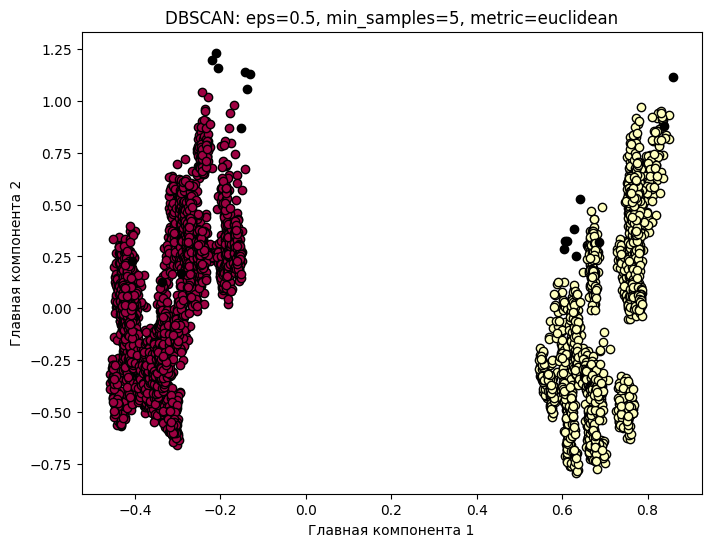

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 0.5
min_samples = 5
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(df)

# Добавляем метки кластеров в DataFrame
df_dbscan = df.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(df[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()


#### **Анализ кластеров**

После применения алгоритма DBSCAN мы получили **два кластера**, между которыми наблюдаются существенные различия по некоторым признакам. Рассмотрим три наиболее значимых признака:

1. **Type_White (Тип вина):**
   - **Кластер 0** состоит исключительно из красных вин (значение `mean = 0.0`).
   - **Кластер 1** состоит исключительно из белых вин (значение `mean = 1.0`).

2. **Volatile Acidity:**
   - **Кластер 0** (красные вина) имеет более высокое среднее значение летучей кислотности (`mean ≈ 0.299`), чем **Кластер 1** (белые вина) со средним значением (`mean ≈ 0.132`).

3. **Total Sulfur Dioxide:**
   - **Кластер 1** (белые вина) имеет значительно более высокое среднее содержание общего диоксида серы (`mean ≈ 0.305`), в сравнении с **Кластером 0** (красные вина) со средним значением (`mean ≈ 0.093`).

**Коэффициент силуэта для DBSCAN:** 0.6136

**Общее заключение:**

Алгоритм DBSCAN успешно разделил вина на два кластера по типу (красное и белое), при этом выявив существенные различия в летучей кислотности и содержании диоксида серы между ними.

### Метрики качества кластеризации

**Дополнительные метрики для оценки качества кластеризации**

Кроме коэффициента силуэта, существуют и другие метрики, которые помогают оценить качество кластеризации. Вот некоторые из них:

1. **Индекс Калински-Харабаза (Calinski-Harabasz Index):**
   - **Описание:** Измеряет отношение между разбросом между кластерами и разбросом внутри кластеров.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к бесконечности больше, тем лучше раздленеие между кластерами

2. **Индекс Дэвиса-Болдина (Davies-Bouldin Index):**
   - **Описание:** Оценивает среднее "сходство" между каждым кластером и наиболее похожим на него другим кластером. Сходство основано на расстоянии между кластерами и их размером.
   - **Диапазон значений:** От 0 до бесконечности.
   - **Интерпретация:** Чем ближе к 0, тем лучшее разделение между кластерами.

3. **Коэффициент силуэта (Silhouette Score):**

    - **Описание:** Измеряет, насколько объект похож на свой кластер по сравнению с другими кластерами.
    - **Диапазон значений:** От -1 до 1.
    - **Интерпретация:** Значения, близкие к 1, указывают на хорошую кластеризацию. Значения около 0 означают, что кластеры перекрываются. Отрицательные значения указывают на возможные ошибки в кластеризации.

In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(df, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(df, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(df, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 1391.6305
Индекс Дэвиса-Болдина для K-means: 1.6960
Коэффициент силуэта для K-means: 0.2164


In [ ]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = df[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")


Индекс Калински-Харабаза для DBSCAN: 3102.4844
Индекс Дэвиса-Болдина для DBSCAN: 1.2475
Коэффициент силуэта для DBSCAN: 0.3651


#### Визуальный пример

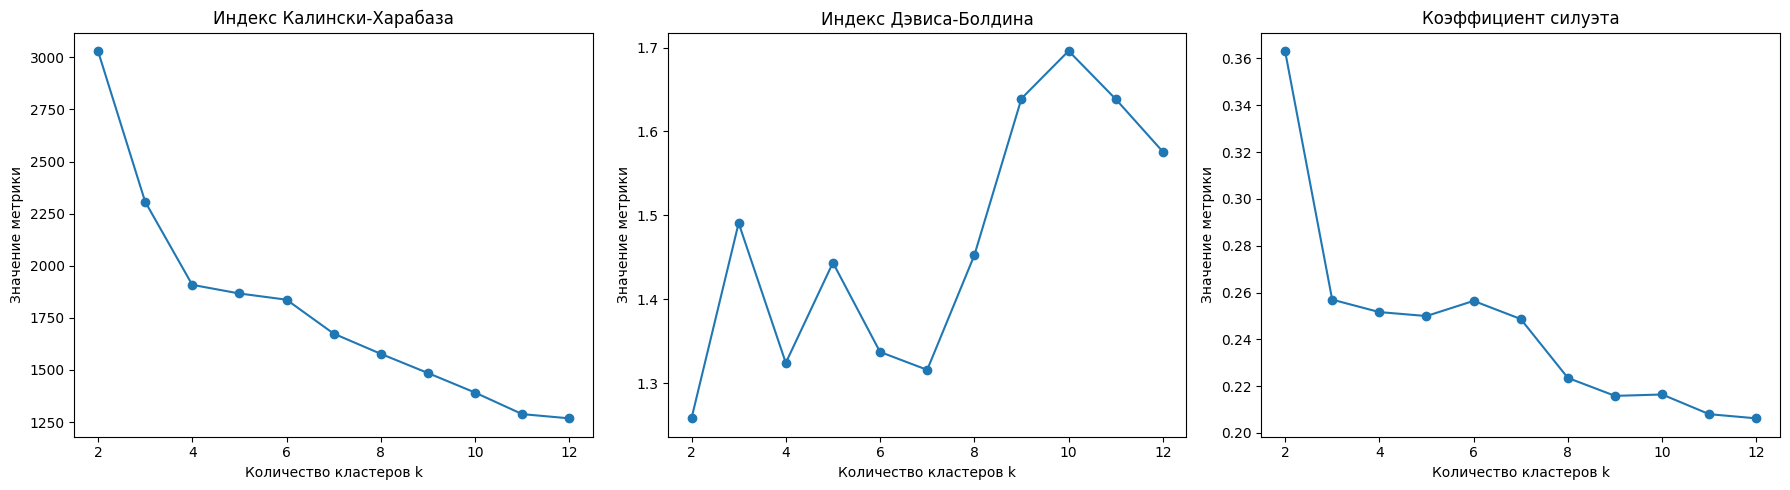

In [ ]:
# Диапазон значений k
k_range = range(2, 13)

# Списки для хранения метрик
ch_scores = []
db_scores = []
silhouette_scores = []

for k in k_range:
    # Создаем и обучаем модель KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)

    # Вычисляем метрики
    ch_score = calinski_harabasz_score(df, labels)
    db_score = davies_bouldin_score(df, labels)
    silhouette_avg = silhouette_score(df, labels)

    # Сохраняем метрики
    ch_scores.append(ch_score)
    db_scores.append(db_score)
    silhouette_scores.append(silhouette_avg)

# Построение графиков
plt.figure(figsize=(18, 5))

# График Индекса Калински-Харабаза
plt.subplot(1, 3, 1)
plt.plot(k_range, ch_scores, marker='o')
plt.title('Индекс Калински-Харабаза')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Индекса Дэвиса-Болдина
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.title('Индекс Дэвиса-Болдина')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Коэффициента силуэта
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

plt.tight_layout()
plt.show()


# Пример обработки текстовых данных

In [ ]:
pip install nltk pymorphy2 scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=264043435524221fc250d7f70e4c868ae3f62f7004c33b99d0aeea81f75eb5de
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Инициализация текстовых анализаторов

In [ ]:
# Инициализируем лемматизатор и список стоп-слов
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words('russian')

# Чтение данных из файла
with open('/content/articles.txt', 'r', encoding='utf-8') as f:
    content = f.read()

# Разделяем данные на статьи
articles_raw = content.split('=====')

# Извлекаем заголовки и тексты статей
titles = []
texts = []

for article in articles_raw:
    lines = article.strip().split('\n')
    if len(lines) >= 6:
        # Извлекаем заголовок и текст статьи
        title = lines[4]
        text = ' '.join(lines[5:])
        titles.append(title)
        texts.append(text)

In [ ]:
texts[:2]

['Большинство из нас видит Отечественную войну 1812 года глазами ее величайшего популяризатора – Льва Толстого. Формально «Война и мир» – книга художественная, но и автор, и многие читатели воспринимали ее как эпическое полотно из реального мира, в которое Толстой просто вплел судьбы кое-каких персонажей помельче. Из-за «толстовизации» истории Отечественной войны многие до сих пор считают, что Кутузов как полководец действовал мудро. Якобы он не хотел давать Наполеону Бородинского сражения, планируя скорее отдать Москву, и только под напором Александра I и двора это сражение он дал. Более того, Кутузов не хотел жертв со стороны русской армии и поэтому избегал решительных сражений с французами при их отступлении вдоль Старой смоленской дороги, и также поэтому не окружил их под Красным, еще в глубине России, где до границы было очень далеко. По той же причине же он не хотел и решительного сражения с Наполеоном на Березине, не гнал вперед свои уставшие войска, и от этого разгром Бонапарта

#### Предварительная обработка текстовых данных

1. преобразуем в lowercase
2. оставляем только слова
3. токенизируем текста
4. преобразуем слова в начальную форму

In [ ]:
russian_stopwords

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [ ]:
def preprocess_text(text):
    # Приводим к нижнему регистру
    text = text.lower()
    # Удаляем пунктуацию и цифры
    text = re.sub(r'[^а-яё\s]', '', text)
    # Токенизация
    words = text.split()
    # Удаление стоп-слов и лемматизация
    lemmatized = []
    for word in words:
        if word not in russian_stopwords:
            lemma = morph.parse(word)[0].normal_form
            lemmatized.append(lemma)
    return ' '.join(lemmatized)

# Применяем предобработку к каждому тексту
texts_preprocessed = [preprocess_text(text) for text in texts]


In [ ]:
texts_preprocessed[:2]

#### Преобразуем в векторный вид

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_preprocessed)


In [ ]:
# Параметры DBSCAN могут требовать подбора
dbscan = DBSCAN(eps=0.5, min_samples=2, metric='cosine')
labels = dbscan.fit_predict(X)


In [ ]:
# Создаем DataFrame с заголовками и метками кластеров
df = pd.DataFrame({'title': titles, 'label': labels})

# Выводим количество кластеров
unique_labels = set(labels)
n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
print(f'Количество кластеров: {n_clusters}')

# Анализируем кластеры
for label in unique_labels:
    if label == -1:
        continue  # Пропускаем шум
    cluster_titles = df[df['label'] == label]['title'].head(3)
    print(f'\nКластер {label}:')
    for title in cluster_titles:
        print(f'- {title}')


Количество кластеров: 51

Кластер 0:
- Впервые в мире термоядерную плазму протестировали в токамаке нового поколения 
- Создан самый большой в мире термоядерный стелларатор 

Кластер 1:
- Во «ВКонтакте»  запущена биржа рекламы 
- «ВКонтакте» избавится от назойливой рекламы в ленте новостей 

Кластер 2:
- Первый китайский луноход 
- Миссия «Чанъэ-3»: Китай хочет утвердиться в качестве космической сверхдержавы 
- «Чанъэ-3» сделал фото Земли в высоком разрешении 

Кластер 3:
- Гибридное затмение над Африкой 
- В воскресенье произойдет гибридное солнечное затмение 

Кластер 4:
- LG G Flex: изогнутый – значит гибкий 
- LG G Flex – «первый в мире по-настоящему изогнутый»  смартфон 

Кластер 5:
- Будет ли Сноуден  работать во «ВКонтакте»? 
- Сноуден отказался работать в соцсети «ВКонтакте» 
- Сноуден  начнет работать в «крупнейшем российском сайте» 

Кластер 6:
- Злой двойник Земли 
- 9 самых странных экзопланет 
- Телескоп «Кеплер» обнаружил планету, похожую на Землю 

Кластер 7:
- Черная ды

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# Применяем PCA для уменьшения размерности до 3 компонент
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

# Создаем DataFrame для визуализации
df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 2],
    'title': titles,
    'label': labels
})

# Создаем 3D Scatter Plot
fig = go.Figure(data=[go.Scatter3d(
    x=df_plot['PC1'],
    y=df_plot['PC2'],
    z=df_plot['PC3'],
    mode='markers',
    marker=dict(
        size=5,
        color=df_plot['label'],
        colorscale='Viridis',
        opacity=0.8
    ),
    text=df_plot['title'],
    hovertemplate='%{text}<extra></extra>'
)])

# Настраиваем внешний вид графика
fig.update_layout(
    title='3D PCA визуализация статей',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=50)
)

# Генерируем кадры для анимации вращения графика
frames = []
for angle in range(0, 360, 10):
    camera = dict(
        eye=dict(x=2*np.cos(np.radians(angle)), y=2*np.sin(np.radians(angle)), z=1.5)
    )
    frames.append(go.Frame(layout=dict(scene_camera=camera)))

# Добавляем кадры в график
fig.frames = frames

# Добавляем кнопки управления анимацией
fig.update_layout(
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        y=0.8,
        x=1.05,
        xanchor='left',
        yanchor='top',
        buttons=[dict(label='Вращать',
                      method='animate',
                      args=[None, dict(frame=dict(duration=50, redraw=True),
                                       transition=dict(duration=0),
                                       fromcurrent=True,
                                       mode='immediate')])]
    )]
)

# Отображаем график
fig.show()
